In [3]:
import cv2
import numpy as np
import math
from skimage.segmentation import slic
from skimage.measure import label, regionprops
from skimage import color as skcolor
from sklearn.cluster import KMeans

##############################################################################
# Utility Functions
##############################################################################

def rgb_to_hsv_np(img):
    """Convert an RGB image [0..1] to HSV [0..1], using skimage for convenience."""
    # skimage.color.rgb2hsv expects float64 in [0..1].
    return skcolor.rgb2hsv(img.astype(np.float64))

def hsv_to_rgb_np(img):
    """Convert an HSV image [0..1] to RGB [0..1], using skimage for convenience."""
    return skcolor.hsv2rgb(img)

def bgr_to_lab(img_bgr):
    """Convert a BGR [0..255] image to Lab [0..255] using OpenCV."""
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)

def lab_to_bgr(img_lab):
    """Convert a Lab [0..255] image to BGR [0..255] using OpenCV."""
    return cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)

def delta_e94(lab1, lab2):
    """
    Approximate ΔE94 between two Lab colors.
    Each is (L, a, b). This is a simplified version from the paper.
    """
    # Paper uses: ΔE94 = sqrt((ΔL/KL)^2 + (ΔAB/(1 + K1*AB1))^2 + (ΔH/(1 + K2*AB1))^2)
    # We'll do a simpler approach or partial approach for demonstration.

    L1, a1, b1 = lab1
    L2, a2, b2 = lab2
    dL = L1 - L2
    C1 = math.sqrt(a1*a1 + b1*b1)
    C2 = math.sqrt(a2*a2 + b2*b2)
    dC = C1 - C2
    dA = a1 - a2
    dB = b1 - b2
    dH_sq = (dA*dA + dB*dB - dC*dC) if (dC*dC <= (dA*dA + dB*dB)) else 0.0

    # Constants from paper:
    KL = 2.0
    K1 = 0.048
    K2 = 0.014

    # We compute approximate AB1 as the average of C1, from the paper's eqn:
    AB1 = C1
    # For simplicity, we do a direct approach:
    termL = (dL / KL)**2
    termC = (dC / (1 + K1 * AB1))**2
    termH = (math.sqrt(abs(dH_sq)) / (1 + K2 * AB1))**2

    return math.sqrt(termL + termC + termH)

def compute_saliency_opencv(img_bgr):
    """Compute saliency using OpenCV's spectral residual method."""
    saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
    success, saliency_map = saliency.computeSaliency(img_bgr)
    if not success:
        # fallback: just return grayscale
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        return gray.astype(np.float32) / 255.0
    return saliency_map.astype(np.float32)

def guided_filter_color(I, p, radius=5, eps=1e-3):
    """
    Simple approximate guided filter using OpenCV's ximgproc if available.
    If not, we do a basic bilateral filter fallback.
    """
    # Try to import guided filter from opencv-contrib
    try:
        import cv2.ximgproc as xip
        # p and I must be 8-bit or 32F
        if p.dtype != np.float32:
            p = p.astype(np.float32)
        if I.dtype != np.float32:
            I = I.astype(np.float32)
        guided = xip.guidedFilter(I, p, radius, eps)
        return guided
    except ImportError:
        # fallback: use a bilateral filter as a rough approximation
        return cv2.bilateralFilter(p, radius*2+1, 75, 75)

##############################################################################
# 1. Dominant Color Estimation (Grid-based in HSV)
##############################################################################

def estimate_dominant_colors(img_bgr, grid_size=8, min_pixels=50):
    """
    Implements the grid-based dominant color estimation in HSV from the paper (Sec. 3.1.1),
    but in a simplified manner:
      1. Convert image to HSV.
      2. Create a 3D histogram with shape [grid_size, grid_size, grid_size].
      3. Remove outlier bins using a threshold (3-sigma or min_pixels).
      4. Merge connected bins to find final 'dominant color' centroids.
    Returns a list of HSV colors in [0..255].
    """
    h, w, _ = img_bgr.shape
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)  # each channel [0..180] for H, [0..255] for S,V

    # 3D histogram: We'll use integer binning. H range: 0..180, S range: 0..256, V range: 0..256
    # We want grid_size bins for each channel => bin width:
    h_bin = 180 / grid_size
    s_bin = 256 / grid_size
    v_bin = 256 / grid_size

    # Build the histogram
    hist_3d = np.zeros((grid_size, grid_size, grid_size), dtype=np.int32)
    for y in range(h):
        for x in range(w):
            H, S, V = img_hsv[y, x]
            hi = int(H // h_bin)
            si = int(S // s_bin)
            vi = int(V // v_bin)
            if hi >= grid_size: hi = grid_size - 1
            if si >= grid_size: si = grid_size - 1
            if vi >= grid_size: vi = grid_size - 1
            hist_3d[hi, si, vi] += 1

    # Remove outliers (bins with fewer than min_pixels)
    mask = (hist_3d >= min_pixels).astype(np.uint8)

    # We now find connected components in 3D (26-neighborhood).
    # We'll label them and compute centroids in HSV bin space.
    labeled = label(mask, connectivity=3)  # scikit-image 3D labeling
    regions = regionprops(labeled)
    dominant_hsv = []
    for r in regions:
        # regionprops centroid is in (z,y,x) order if 3D, but our labeling might be (hi,si,vi).
        coords = r.coords  # list of (hi, si, vi)
        total_count = 0
        sumH = 0
        sumS = 0
        sumV = 0
        for (hi, si, vi) in coords:
            count = hist_3d[hi, si, vi]
            # The actual H, S, V center of that bin
            # center in bin space => hi+0.5, etc.
            # Convert bin index -> actual H,S,V
            # H in [0..180], bin width = h_bin => actual H ~ (hi+0.5)*h_bin
            # We'll weight by the # of pixels in that bin
            sumH += ( (hi + 0.5)*h_bin ) * count
            sumS += ( (si + 0.5)*s_bin ) * count
            sumV += ( (vi + 0.5)*v_bin ) * count
            total_count += count

        if total_count > 0:
            cH = sumH / total_count
            cS = sumS / total_count
            cV = sumV / total_count
            # store as integer
            cH = np.clip(cH, 0, 179)
            cS = np.clip(cS, 0, 255)
            cV = np.clip(cV, 0, 255)
            dominant_hsv.append([cH, cS, cV])

    # Return as a list of HSV in [0..255], H in [0..179].
    # The paper merges them further if needed. We'll just return them.
    return dominant_hsv

##############################################################################
# 2. Soft Segmentation via Cost Volume + Guided Filtering
##############################################################################

def soft_segmentation(img_bgr, dom_hsv_list):
    """
    Soft-segment the image based on the dominant colors (Sec. 3.1.2).
    Steps:
      1) Convert each dominant color to Lab for cost computation.
      2) For each pixel, compute cost = ΔE94(Lab_pixel, Lab_dominant).
      3) Filter cost volumes with a guided filter (paper used cost-volume filtering).
      4) Convert to soft segmentation by normalized exp(-cost).
    Returns: seg_map with shape [H,W,len(dom_hsv_list)] => sum over last dim = 1.
    """
    H, W, _ = img_bgr.shape
    img_lab = bgr_to_lab(img_bgr).astype(np.float32)
    # Precompute Lab for each pixel
    lab_pixels = img_lab.reshape(-1, 3)

    # Convert each dominant HSV to BGR->Lab for cost
    dom_lab_list = []
    for hsv in dom_hsv_list:
        color_bgr = np.uint8([[hsv]])  # shape(1,1,3) in HSV
        color_bgr = cv2.cvtColor(color_bgr, cv2.COLOR_HSV2BGR)
        color_lab = cv2.cvtColor(color_bgr, cv2.COLOR_BGR2LAB)[0,0,:].astype(np.float32)
        dom_lab_list.append(color_lab)

    # Build cost volumes
    cost_volumes = []
    for cidx, dom_lab in enumerate(dom_lab_list):
        cost_map = np.zeros((H, W), dtype=np.float32)
        for i in range(H):
            for j in range(W):
                Lp, Ap, Bp = img_lab[i,j]
                cost_map[i,j] = delta_e94((Lp,Ap,Bp), dom_lab)
        # Filter cost_map with guided filter using the original image as guidance
        # (paper uses cost-volume filtering, we approximate with guidedFilter on each slice).
        # Convert BGR to float32 for guided filter
        guided = img_bgr.astype(np.float32) / 255.0
        cost_map_filtered = guided_filter_color(guided, cost_map, radius=5, eps=1e-3)
        cost_volumes.append(cost_map_filtered)

    # Convert cost to soft membership
    # We'll do: membership = exp(-cost / alpha), then normalize
    alpha = 10.0  # scale factor to control softness
    seg_stack = []
    for cvm in cost_volumes:
        seg_stack.append(np.exp(-cvm / alpha))

    seg_stack = np.stack(seg_stack, axis=-1)  # shape(H,W,#dom)
    sum_ = np.sum(seg_stack, axis=-1, keepdims=True)
    sum_ = np.clip(sum_, 1e-8, None)
    seg_stack /= sum_
    return seg_stack

##############################################################################
# 3. Region Matching
##############################################################################

def compute_region_features(img_bgr, seg_stack):
    """
    Compute region features: saliency, luminance, pixel ratio for each
    dominant-color region. We'll pick the argmax per pixel as 'hard region label'
    to measure stats. (Paper does 'winner-take-all' in cost volume).
    """
    H, W, C = seg_stack.shape
    # Hard assignment
    labels = np.argmax(seg_stack, axis=-1).astype(np.int32)  # shape(H,W)
    # Saliency map
    sal_map = compute_saliency_opencv(img_bgr)

    # Luminance from Lab
    img_lab = bgr_to_lab(img_bgr)
    L_chan = img_lab[:,:,0].astype(np.float32)

    # For each region, compute average saliency, average L, and pixel ratio
    region_feats = []
    total_pixels = H*W
    for ridx in range(C):
        mask = (labels == ridx)
        pix_count = np.sum(mask)
        if pix_count < 1:
            region_feats.append((0,0,0))  # fallback
            continue
        mean_sal = np.mean(sal_map[mask])
        mean_lum = np.mean(L_chan[mask])
        ratio = float(pix_count) / total_pixels
        region_feats.append((mean_sal, mean_lum, ratio))
    return region_feats

def match_regions(src_feats, tgt_feats, wS=1.0, wL=1.0, wR=1.0):
    """
    From paper eq. (6):
    We find for each src region i => best match j in target that minimizes:
       sqrt( wS*(S_i - S_j)^2 + wL*(L_i - L_j)^2 + wR*(R_i - R_j)^2 )
    Returns a dict: match[i] = j
    """
    match_dict = {}
    for i, (sS, sL, sR) in enumerate(src_feats):
        best_j = None
        best_dist = 1e10
        for j, (tS, tL, tR) in enumerate(tgt_feats):
            dS = (sS - tS)
            dL = (sL - tL)
            dR = (sR - tR)
            dist = math.sqrt(wS*(dS**2) + wL*(dL**2) + wR*(dR**2))
            if dist < best_dist:
                best_dist = dist
                best_j = j
        match_dict[i] = best_j
    return match_dict

##############################################################################
# 4. Local Color Transfer with Modified Reinhard + Local Gamma
##############################################################################

def local_color_transfer(src_bgr, tgt_bgr, src_seg, tgt_seg, match_dict):
    """
    Implements eq. (10)-(12) from paper in a simplified manner:
      - We separate each region in src & tgt
      - For a,b channels => standard Reinhard per region
      - For L => local gamma correction
    We then blend the results using the soft segmentation from src_seg.
    """
    H, W, C = src_seg.shape
    src_lab = bgr_to_lab(src_bgr).astype(np.float32)
    tgt_lab = bgr_to_lab(tgt_bgr).astype(np.float32)

    # Hard labels
    src_labels = np.argmax(src_seg, axis=-1)  # shape(H,W)
    tgt_labels = np.argmax(tgt_seg, axis=-1)

    # We'll build an output Lab
    out_lab = np.zeros_like(src_lab)

    # Precompute region stats (mean, std) for L, a, b in both images
    def compute_region_stats(img_lab, labels, region_idx):
        """Compute (meanL, stdL, meanA, stdA, meanB, stdB) for the given region."""
        mask = (labels == region_idx)
        if not np.any(mask):
            return (0,1, 0,1, 0,1)  # fallback
        region_vals = img_lab[mask]
        L_ = region_vals[:,0]
        A_ = region_vals[:,1]
        B_ = region_vals[:,2]
        return (np.mean(L_), np.std(L_)+1e-6,
                np.mean(A_), np.std(A_)+1e-6,
                np.mean(B_), np.std(B_)+1e-6)

    # We'll store region stats in dict for source & target
    src_stats = {}
    tgt_stats = {}
    src_num_regions = C
    tgt_num_regions = C

    for i in range(src_num_regions):
        src_stats[i] = compute_region_stats(src_lab, src_labels, i)
    for j in range(tgt_num_regions):
        tgt_stats[j] = compute_region_stats(tgt_lab, tgt_labels, j)

    # Local gamma parameters from eq. (12)
    # We'll compute global L means:
    src_global_L = np.mean(src_lab[:,:,0])
    tgt_global_L = np.mean(tgt_lab[:,:,0])

    # For each pixel in src, do:
    #   region i => matched region j
    #   a*, b* => eq. (10),(11)
    #   L => eq. (12) local gamma
    out_L = np.zeros((H,W), dtype=np.float32)
    out_A = np.zeros((H,W), dtype=np.float32)
    out_B = np.zeros((H,W), dtype=np.float32)

    for i in range(H):
        for j in range(W):
            ridx = src_labels[i,j]
            matched_r = match_dict[ridx]
            # get stats
            sMeanL, sStdL, sMeanA, sStdA, sMeanB, sStdB = src_stats[ridx]
            tMeanL, tStdL, tMeanA, tStdA, tMeanB, tStdB = tgt_stats[matched_r]

            Lp, Ap, Bp = src_lab[i,j]

            # eq. (10),(11) for a,b
            a_new = ((Ap - sMeanA) * (tStdA / sStdA)) + tMeanA
            b_new = ((Bp - sMeanB) * (tStdB / sStdB)) + tMeanB

            # eq. (12) for L => local gamma
            # gamma_i = |beta_i + alpha*(μLs - μLt)|
            #   beta_i = [1 + 2(μli - μlj)]
            #   alpha = exp( |Ls - Lt| * (μli/μLs - μlj/μLt) )
            # We'll interpret "μli" as sMeanL, "μlj" as tMeanL
            # and Ls=src_global_L, Lt=tgt_global_L
            mu_li = sMeanL
            mu_lj = tMeanL
            Ls = src_global_L
            Lt = tgt_global_L

            beta_i = (1.0 + 2.0*(mu_li - mu_lj)/255.0)  # scaled by 255
            # Protect from negative or zero
            # alpha_i = exp(|Ls - Lt| * ( (mu_li/μLs) - (mu_lj/μLt) ))
            # The paper's exact formula is a bit ambiguous; we do a best guess:
            #   alpha = exp( |Ls-Lt| * ( (mu_li/Ls) - (mu_lj/Lt) ) )
            # We'll clamp to avoid negative or zero denominators
            Ls = max(Ls, 1e-6)
            Lt = max(Lt, 1e-6)
            alpha_i = math.exp(abs(Ls - Lt) * ((mu_li/Ls) - (mu_lj/Lt)))

            gamma_i = abs(beta_i + alpha_i*(Ls - Lt)/255.0)  # extra scaling
            # now L' = L^gamma_i, but we want to keep it in [0..255].
            # The paper's eq. (12) says: L0 = sum( (Li)^gamma_i ), but we have per-pixel approach
            # We'll do: L_new = (Lp/255)^gamma_i * 255
            # This is a simplified approach.
            Lp_norm = Lp / 255.0
            L_new = (Lp_norm ** gamma_i) * 255.0

            out_L[i,j] = np.clip(L_new, 0, 255)
            out_A[i,j] = np.clip(a_new, 0, 255)
            out_B[i,j] = np.clip(b_new, 0, 255)

    # Combine into Lab
    combined_lab = np.stack([out_L, out_A, out_B], axis=-1).astype(np.uint8)

    # Because we did a "hard" approach per pixel, we can blend with the soft weights from src_seg
    # But the paper merges them region by region. We'll do a simpler approach:
    #   out_lab is final.
    return combined_lab

##############################################################################
# Main Pipeline
##############################################################################

def local_color_transfer_pipeline(source_path, target_path):
    """
    Full pipeline from the Yoo et al. paper, approximate version.
    1) Estimate dominant colors in both images.
    2) Soft-segment both images.
    3) Region matching by saliency, luminance, pixel ratio.
    4) Local color transfer with local gamma correction.
    """
    # Load images
    src_bgr = cv2.imread(source_path)
    tgt_bgr = cv2.imread(target_path)
    if src_bgr is None or tgt_bgr is None:
        raise IOError("Could not load source or target image.")

    # 1) Dominant colors
    src_dom = estimate_dominant_colors(src_bgr, grid_size=8, min_pixels=50)
    tgt_dom = estimate_dominant_colors(tgt_bgr, grid_size=8, min_pixels=50)

    # 2) Soft segmentation
    src_seg = soft_segmentation(src_bgr, src_dom)  # shape(H,W,Cs)
    tgt_seg = soft_segmentation(tgt_bgr, tgt_dom)  # shape(H,W,Ct)

    # For simplicity, we assume the same number of dominant colors in both images.
    # If they differ, you can keep only the min(C_s, C_t) largest segments or similar.
    # We'll just truncate to min length:
    Cs = src_seg.shape[-1]
    Ct = tgt_seg.shape[-1]
    C_min = min(Cs, Ct)
    src_seg = src_seg[:,:,:C_min]
    tgt_seg = tgt_seg[:,:,:C_min]

    # 3) Region matching
    src_feats = compute_region_features(src_bgr, src_seg)
    tgt_feats = compute_region_features(tgt_bgr, tgt_seg)
    match_dict = match_regions(src_feats, tgt_feats, wS=1.0, wL=1.0, wR=1.0)

    # 4) Local color transfer
    out_lab = local_color_transfer(src_bgr, tgt_bgr, src_seg, tgt_seg, match_dict)
    out_bgr = lab_to_bgr(out_lab)
    return out_bgr




In [6]:
##############################################################################
# Demo Main
##############################################################################

if __name__ == "__main__":
    # Example usage with the two beach images:
    source_path = "/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/beach_ref.jpeg"  # The image to be recolored
    target_path = "/home/neelraj-reddy/college/6th_sem/computer vision/project/A little survey on previous works/images/beach_target.jpeg"     # The reference style image

    result_bgr = local_color_transfer_pipeline(source_path, target_path)
    out_name = "local_color_result.jpg"


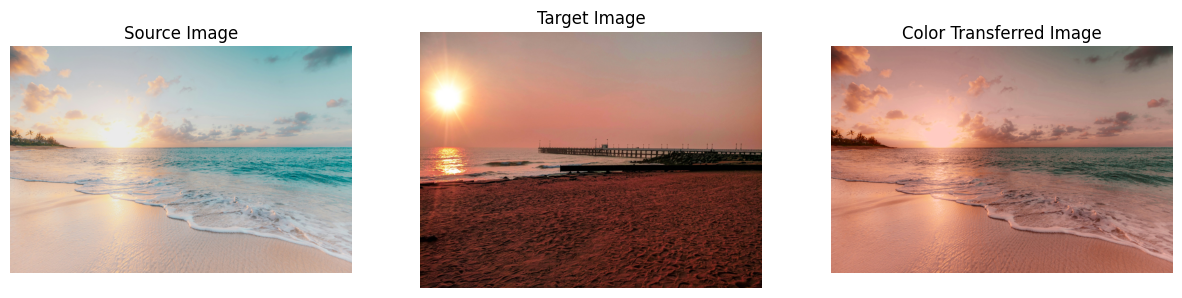

In [8]:
import matplotlib.pyplot as plt

# Load original and target images
source_img = cv2.imread(source_path)
target_img = cv2.imread(target_path)

# Convert BGR to RGB for correct color display in matplotlib
source_rgb = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
target_rgb = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
result_rgb = cv2.cvtColor(result_bgr, cv2.COLOR_BGR2RGB)

# Plot all three images for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(source_rgb)
plt.axis('off')
plt.title("Source Image")

plt.subplot(1, 3, 2)
plt.imshow(target_rgb)
plt.axis('off')
plt.title("Target Image")

plt.subplot(1, 3, 3)
plt.imshow(result_rgb)
plt.axis('off')
plt.title("Color Transferred Image")

plt.show()
